In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

%matplotlib inline
#%matplotlib qt

In [3]:
# read in a calibration image
images = glob.glob('C:/Udacity/CarND-Advanced-Lane-Lines-master/camera_cal/calibration*.jpg')

# Arrays  to store object points and image points from al the images
objpoints = [] # 3D points
imgpoints = [] # 2D points

# Prepare object points like (0,0,0), (1,0,0), (2,0,0) ..., (8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates


In [4]:
for fname in images:
	# read in each image
	img = mpimg.imread(fname)

	# convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	# find the chessboard corners
	ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

	# if corners are found, add object points and image points
	if ret == True:
		imgpoints.append(corners)
		objpoints.append(objp)
		
		# drax and display the corners
		img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

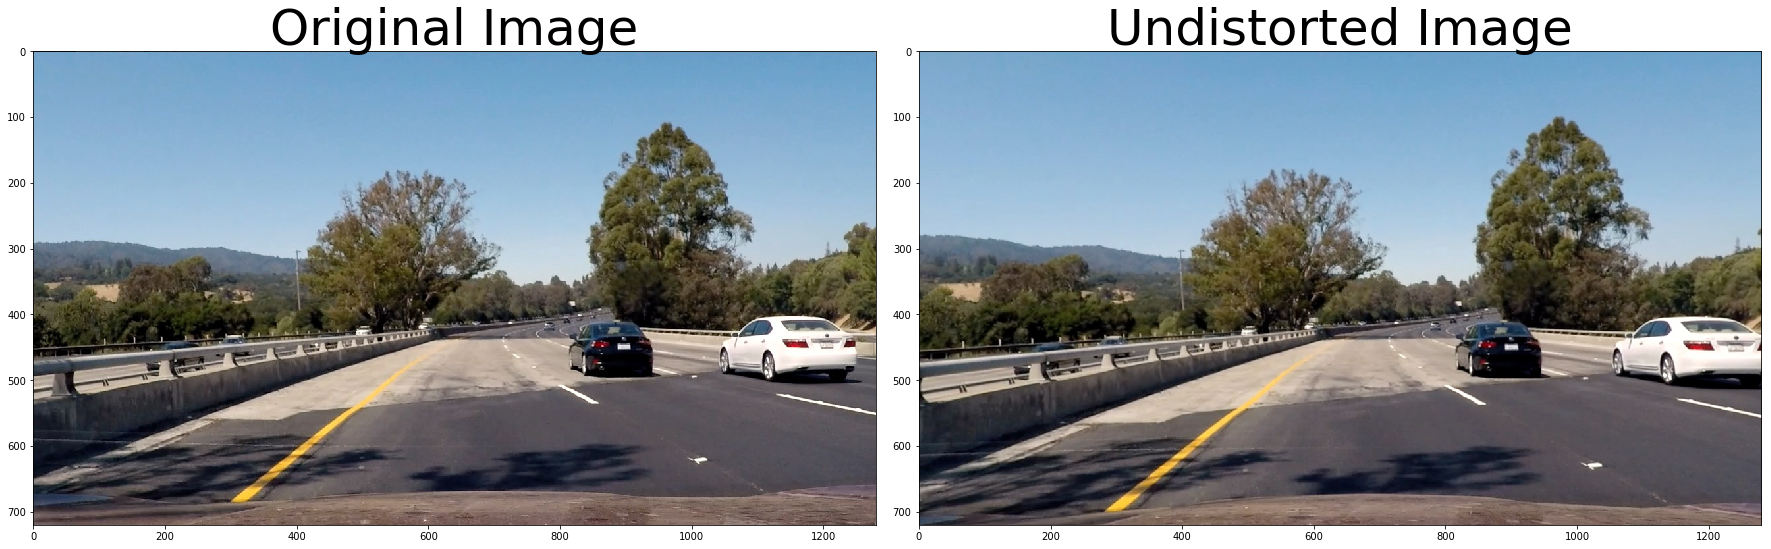

In [5]:
img_visu_0 = mpimg.imread('C:/Udacity/CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg')
img_visu = mpimg.imread('C:/Udacity/CarND-Advanced-Lane-Lines-master/test_images/test4.jpg')

def undistort_img(img, mtx, dist):
    
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

def visu_undist(img, mtx, dist):
    
    undist_img = undistort_img(img, mtx, dist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undist_img)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
visu_undist(img_visu, mtx, dist)

=== PERSPECTIVE TRANSFORM ===
===============

In [6]:
# Define perspective tranform function
def warp(img, src, dst):
	
	# Compute the perspective transform M
	M = cv2.getPerspectiveTransform(src, dst)
	
	# Could compute the inverse also by swapping the input parameters
	Minv = cv2.getPerspectiveTransform(dst, src)
	
	# Create warped image - uses linear interpolation
	warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

	return warped, Minv

(720, 1280, 3)


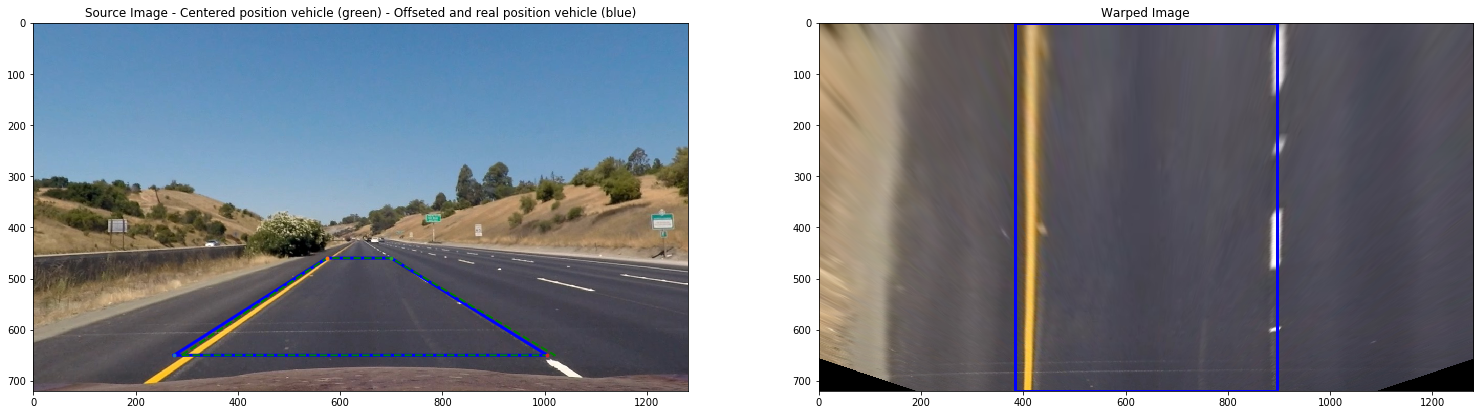

In [7]:
# Define calibration box in source (original) and destination (desired or wraped) coordinates
h, w = 720, 1280 #img.shape[:2]  # h : height of the image, w : width of the image
    
# Four source coordinates
src = np.float32([[275, 650],
					[574, 460],
					[700, 460],
					[1005, 650]])
    
# Four destinate coordinates
dst = np.float32([[w*.3,h],
					[w*.3,0],
					[w*.7,0],
					[w*.7,h]])

def visu_mask(img, src, dst, mtx, dist):
    
    undist_img = undistort_img(img, mtx, dist)
    
    # Get perspective transform
    warped_img, Minv = warp(undist_img, src, dst)
    print(warped_img.shape)

    # Original mask isn't centered on the image so to create perspective transform, I have applied an offset of -15 pixels 
    #on x1, y1 compared to x1_original, y1_original
    x1 = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
    y1 = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]

    x1_original = [src[0][0]+15,src[1][0],src[2][0],src[3][0]+15,src[0][0]+15]
    y1_original = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]

    x2 = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
    y2 = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]


    # Visualisation undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.plot(x1, y1, 'b', linewidth=3)
    ax1.plot(x1_original, y1_original, 'g', linewidth=2, linestyle='--')
    ax1.plot(src[0][0], src[0][1], '.')
    ax1.plot(src[1][0], src[1][1], '.')
    ax1.plot(src[2][0], src[2][1], '.')
    ax1.plot(src[3][0], src[3][1], '.')
    ax1.imshow(undist_img)
    ax1.set_title('Source Image - Centered position vehicle (green) - Offseted and real position vehicle (blue)')
    ax2.plot(x2, y2, 'b', linewidth=3)
    ax2.imshow(warped_img)#, cmap='gray')
    ax2.set_title('Warped Image')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
visu_mask(img_visu_0, src, dst, mtx, dist)

=== COLOR SPACE TRANSFORM ===
===============

In [8]:
def rgb_select(img):
    # 1) Convert to YUV color space
    rgb = img
    R_rgb = rgb[:,:,0]
    G_rgb = rgb[:,:,1]
    B_rgb = rgb[:,:,2]
    
    return rgb, R_rgb, G_rgb, B_rgb

In [9]:
def hls_select(img):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    H_hls = hls[:,:,0]
    L_hls = hls[:,:,1]
    S_hls = hls[:,:,2]

    #binary_output = np.zeros_like(S)
    #binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return hls, H_hls, L_hls, S_hls

In [10]:
def hsv_select(img):
    # 1) Convert to YUV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H_hsv = hsv[:,:,0]
    S_hsv = hsv[:,:,1]
    V_hsv = hsv[:,:,2]
    
    return hsv, H_hsv, S_hsv, V_hsv

In [11]:
def yuv_select(img):
    # 1) Convert to YUV color space
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    Y_yuv = yuv[:,:,0]
    U_yuv = yuv[:,:,1]
    V_yuv = yuv[:,:,2]

    return yuv, Y_yuv, U_yuv, V_yuv

In [12]:
def lab_select(img):
    # 1) Convert to YUV color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L_lab = lab[:,:,0]
    A_lab = lab[:,:,1]
    B_lab = lab[:,:,2]

    return lab, L_lab, A_lab, B_lab

=== Visualization ===

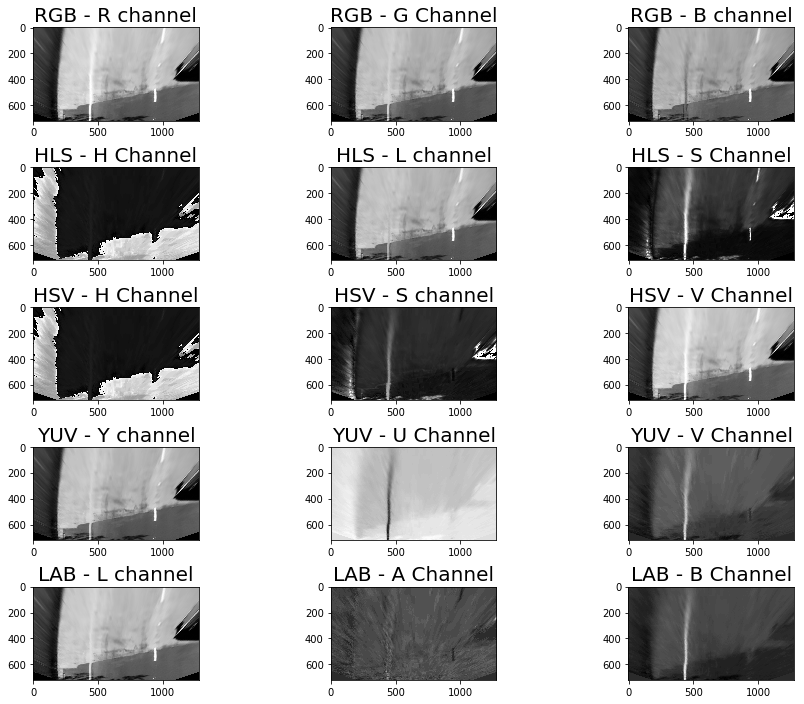

In [13]:
# Test the color space transform on the most difficult image : "test5.jpg"

def visu_color_space(img, src, dst, mtx, dist):
    
    undist_img = undistort_img(img, mtx, dist)
    img_color_space, Minv_test = warp(undist_img, src, dst)
    
    #img_color_space = mpimg.imread('C:/Udacity/CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg')
    #img_color_space = mpimg.imread('C:/Udacity/CarND-Advanced-Lane-Lines-master/test_images/test5.jpg')
    #img_color_space, Minv_test = warp(img_color_space, src, dst)


    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
    hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
    hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
    lab, L_lab, A_lab, B_lab = lab_select(img_color_space)

    fig, axs = plt.subplots(5,3, figsize=(16, 12))
    fig.subplots_adjust(hspace = .2, wspace=0)
    #fig.tight_layout()
    axs = axs.ravel()

    axs[0].imshow(R_rgb, cmap='gray')
    axs[0].set_title('RGB - R channel', fontsize=20)
    axs[1].imshow(G_rgb, cmap='gray')
    axs[1].set_title('RGB - G Channel', fontsize=20)
    axs[2].imshow(B_rgb, cmap='gray')
    axs[2].set_title('RGB - B channel', fontsize=20)

    axs[3].imshow(H_hls, cmap='gray')
    axs[3].set_title('HLS - H Channel', fontsize=20)
    axs[4].imshow(L_hls, cmap='gray')
    axs[4].set_title('HLS - L channel', fontsize=20)
    axs[5].imshow(S_hls, cmap='gray')
    axs[5].set_title('HLS - S Channel', fontsize=20)

    axs[6].imshow(H_hsv, cmap='gray')
    axs[6].set_title('HSV - H Channel', fontsize=20)
    axs[7].imshow(S_hsv, cmap='gray')
    axs[7].set_title('HSV - S channel', fontsize=20)
    axs[8].imshow(V_hsv, cmap='gray')
    axs[8].set_title('HSV - V Channel', fontsize=20)

    axs[9].imshow(Y_yuv, cmap='gray')
    axs[9].set_title('YUV - Y channel', fontsize=20)
    axs[10].imshow(U_yuv, cmap='gray')
    axs[10].set_title('YUV - U Channel', fontsize=20)
    axs[11].imshow(V_yuv, cmap='gray')
    axs[11].set_title('YUV - V Channel', fontsize=20)

    axs[12].imshow(L_lab, cmap='gray')
    axs[12].set_title('LAB - L channel', fontsize=20)
    axs[13].imshow(A_lab, cmap='gray')
    axs[13].set_title('LAB - A Channel', fontsize=20)
    axs[14].imshow(B_lab, cmap='gray')
    axs[14].set_title('LAB - B Channel', fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.001)
    #print('Color space transform on original image', fontsize = 20)
    
    return None
    
visu_color_space(img_visu, src, dst, mtx, dist)

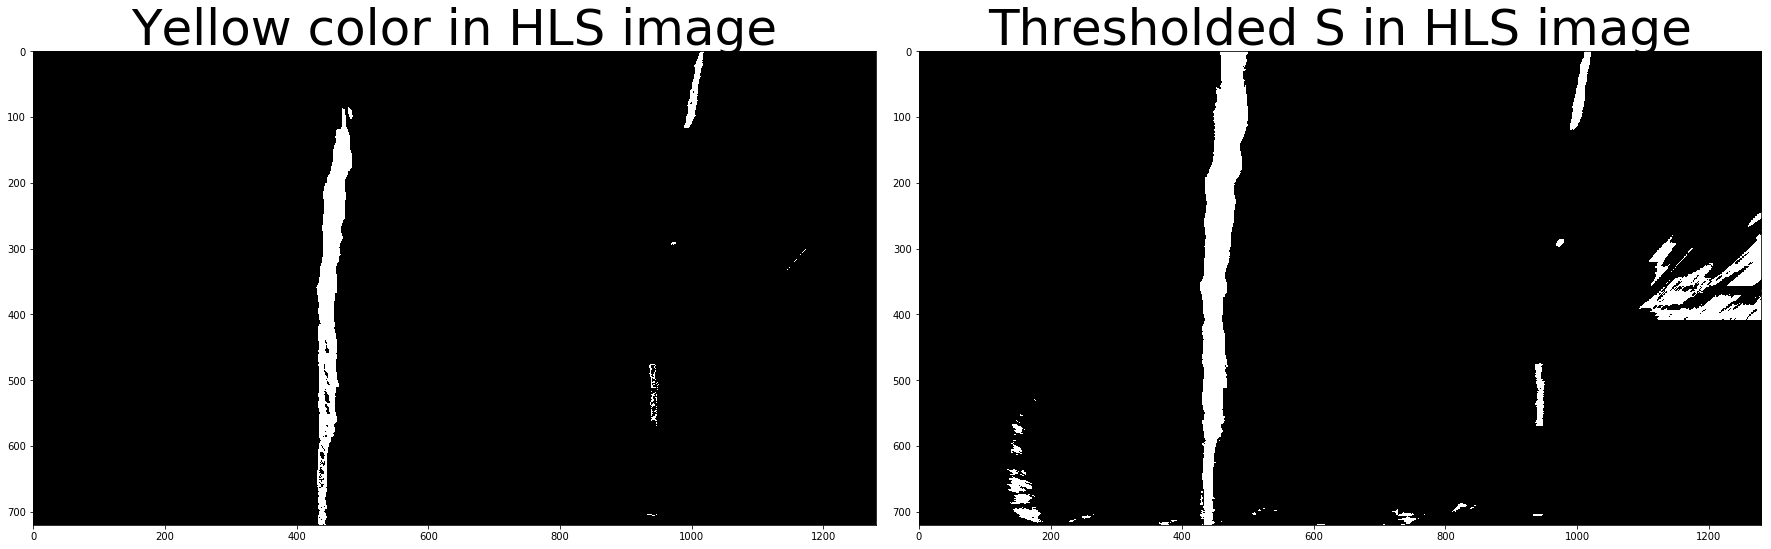

In [14]:
def empirical_yellow_line(img, src, dst, mtx, dist):
    # Empirical detection of yellow color

    undist_img = undistort_img(img, mtx, dist)
    img_color_space, Minv_test = warp(undist_img, src, dst)
    
    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
    hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
    hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
    lab, L_lab, A_lab, B_lab = lab_select(img_color_space)
    
    
    hls_line = np.zeros_like(H_hls)
    hls_line[(H_hls > 0) & (H_hls < 50) & (S_hls > 150) & (S_hls < 255) & (L_hls > 100)] = 1

    hls_binary = np.zeros_like(S_hls)
    hls_binary[(S_hls > 120) ] = 1

    rgb_binary = np.zeros_like(S_hls)
    rgb_binary[(R_rgb > 220) ] = 1

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(hls_line*255, cmap='gray')
    ax1.set_title('Yellow color in HLS image', fontsize=50)
    ax2.imshow(hls_binary, cmap='gray')
    ax2.set_title('Thresholded S in HLS image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return None

empirical_yellow_line(img_visu, src, dst, mtx, dist)

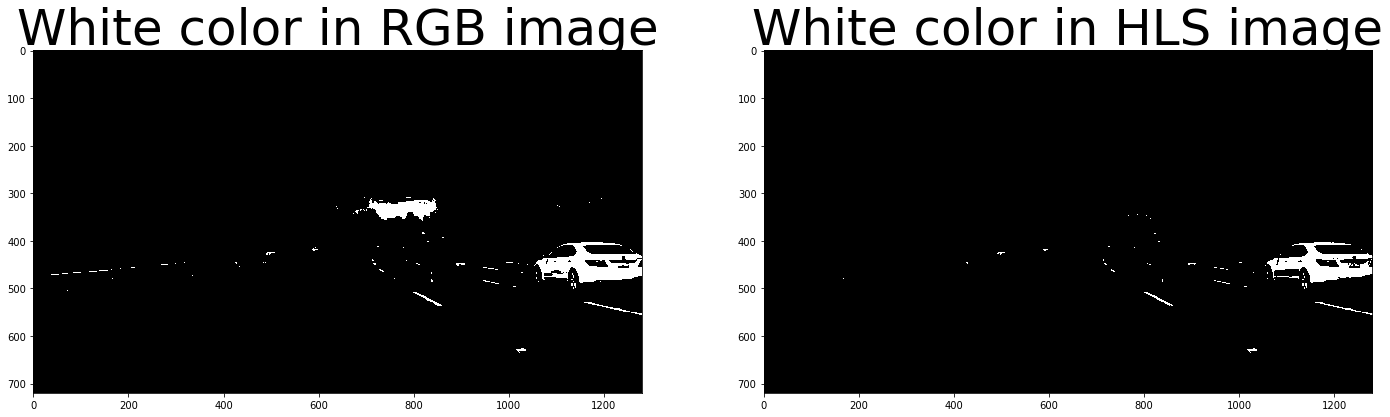

In [15]:
# Find white line

def find_white_line(img, R_rgb, G_rgb, B_rgb, L_hls):
    rgb_white = np.zeros_like(img[:,:,0])
    hls_white = np.zeros_like(img[:,:,0])

    rgb_white[(R_rgb > 200) & (G_rgb > 200) & (B_rgb > 200)] = 1
    hls_white[L_hls > 220] = 1
    return rgb_white, hls_white

### VISUALIZATION
def visu_white_line(img, src, dst, mtx, dist):
    
    img_color_space = undistort_img(img, mtx, dist)
    #img_color_space, Minv_test = warp(undist_img, src, dst)
    
    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
    hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
    hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
    lab, L_lab, A_lab, B_lab = lab_select(img_color_space)
    
    
    rgb_white, hls_white = find_white_line(img_color_space, R_rgb, G_rgb, B_rgb, L_hls)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(rgb_white*255, cmap='gray')
    ax1.set_title('White color in RGB image', fontsize=50)
    ax2.imshow(hls_white*255, cmap='gray')
    ax2.set_title('White color in HLS image', fontsize=50)
    
visu_white_line(img_visu, src, dst, mtx, dist)

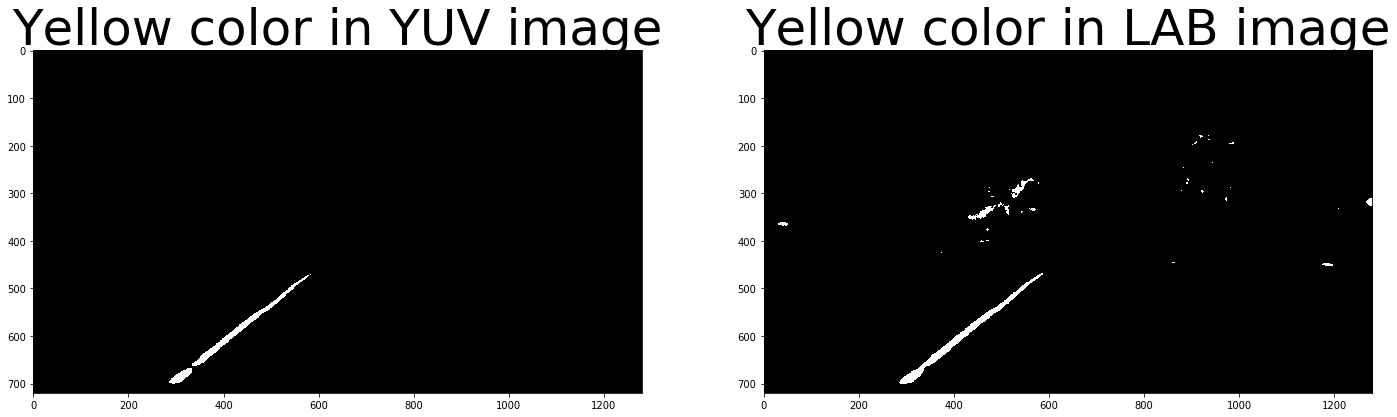

In [16]:
# Find yellow line

def find_yellow_line(img, U_yuv, B_lab):
    yuv_yellow = np.zeros_like(img[:,:,0])
    lab_yellow = np.zeros_like(img[:,:,0])

    yuv_yellow[U_yuv < 100] = 1
    lab_yellow[B_lab > 155] = 1
    return yuv_yellow, lab_yellow

### VISUALIZATION
def visu_yellow_line(img, src, dst, mtx, dist):
    
    img_color_space = undistort_img(img, mtx, dist)
    #img_color_space, Minv_test = warp(undist_img, src, dst)
    
    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
    hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
    hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
    lab, L_lab, A_lab, B_lab = lab_select(img_color_space)
    
    yuv_yellow, lab_yellow = find_yellow_line(img_color_space, U_yuv, B_lab)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(yuv_yellow, cmap='gray')
    ax1.set_title('Yellow color in YUV image', fontsize=50)
    ax2.imshow(lab_yellow, cmap='gray')
    ax2.set_title('Yellow color in LAB image', fontsize=50)
    
visu_yellow_line(img_visu, src, dst, mtx, dist)

=== Combined color threshold for white line ===

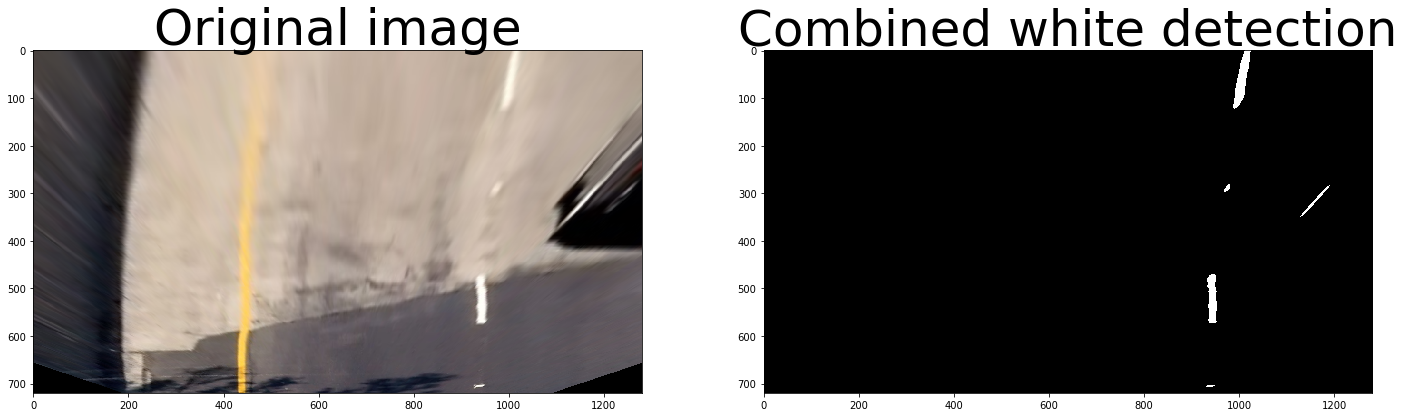

In [17]:
def combined_white_detection(img, R_rgb, G_rgb, B_rgb, L_hls):

    rgb_white, hls_white = find_white_line(img, R_rgb, G_rgb, B_rgb, L_hls)
    
    combined_white = np.zeros_like(img[:,:,0])
    combined_white[((rgb_white == 1) | (hls_white == 1))] = 1
    return combined_white

### VISUALIZATION
def visu_combined_white(img, src, dst, mtx, dist):
    
    undist_img = undistort_img(img, mtx, dist)
    img_color_space, Minv_test = warp(undist_img, src, dst)
    
    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
    hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
    hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
    lab, L_lab, A_lab, B_lab = lab_select(img_color_space)
    
    
    combined_white = combined_white_detection(img_color_space, R_rgb, G_rgb, B_rgb, L_hls)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(img_color_space)
    ax1.set_title('Original image', fontsize=50)
    ax2.imshow(combined_white*255, cmap='gray')
    ax2.set_title('Combined white detection', fontsize=50)
    
visu_combined_white(img_visu, src, dst, mtx, dist)

=== Combined color threshold for yellow line ===

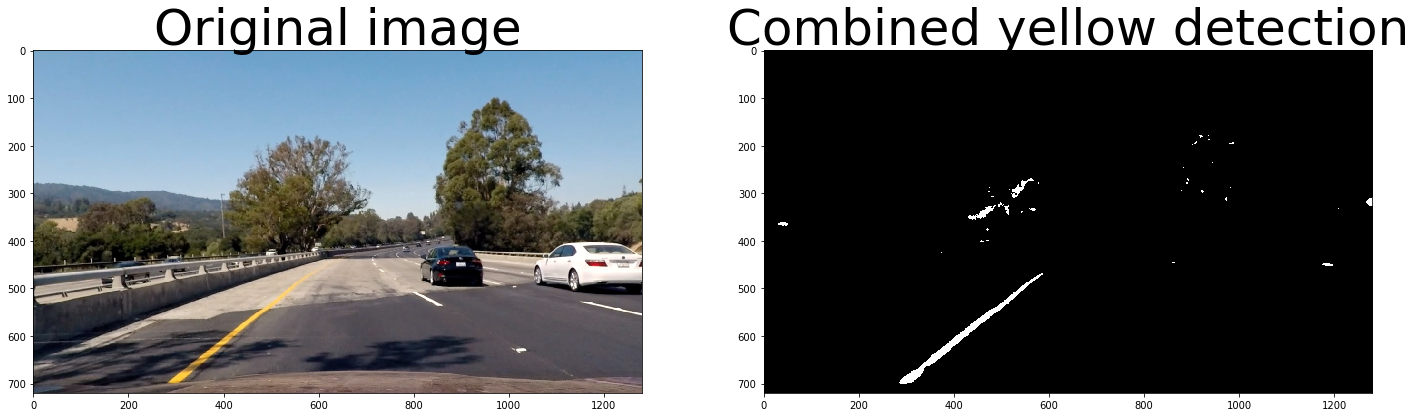

In [18]:
def combined_yellow_detection(img, U_yuv, B_lab):
    
    yuv_yellow, lab_yellow = find_yellow_line(img, U_yuv, B_lab)
    
    combined_yellow = np.zeros_like(img[:,:,0])
    combined_yellow[((yuv_yellow == 1) | (lab_yellow == 1))] = 1
    return combined_yellow

### VISUALIZATION
def visu_combined_yellow(img, src, dst, mtx, dist):
    
    img_color_space = undistort_img(img, mtx, dist)
    #img_color_space, Minv_test = warp(undist_img, src, dst)
    
    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
    hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
    hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
    lab, L_lab, A_lab, B_lab = lab_select(img_color_space)
    
    
    combined_yellow = combined_yellow_detection(img_color_space, U_yuv, B_lab)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(img_color_space)
    ax1.set_title('Original image', fontsize=50)
    ax2.imshow(combined_yellow, cmap='gray')
    ax2.set_title('Combined yellow detection', fontsize=50)
    
visu_combined_yellow(img_visu, src, dst, mtx, dist)

=== GRADIENT ===
=========

In [19]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
	# Calculate directional gradient
	# Apply threshold
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	if orient == 'x':
		sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	elif orient == 'y':
		sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	abs_sobel = np.absolute(sobel)
	scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
	grad_binary = np.zeros_like(scaled_sobel)
	grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
	return grad_binary
	
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
	# Calculate gradient magnitude
	# Apply threshold
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
	scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
	mag_binary = np.zeros_like(scaled_sobel)
	mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
	return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
	# Calculate gradient direction
	# Apply threshold
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	abs_sobelx = np.absolute(sobelx)
	abs_sobely = np.absolute(sobely)
	dir_grad = np.arctan2(abs_sobely, abs_sobelx)
	dir_binary = np.zeros_like(dir_grad)
	dir_binary[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
	return dir_binary

=== VISUALIZATION ===

(720, 1280)


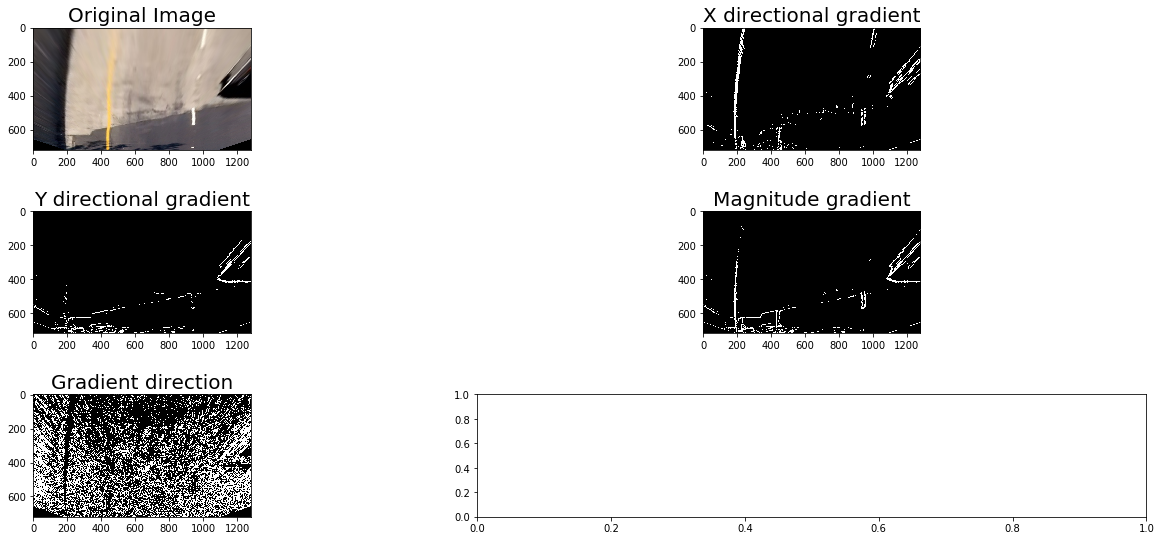

In [20]:
def visu_gradient(img, src, dst, mtx, dist):

    undist_img = undistort_img(img, mtx, dist)
    img_color_space, Minv_test = warp(undist_img, src, dst)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img_color_space, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img_color_space, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img_color_space, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(img_color_space, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    print(gradx.shape)

    # Plot the result
    f, axs = plt.subplots(3, 2, figsize=(24, 9))
    f.subplots_adjust(hspace = .2, wspace=0)
    #f.tight_layout()
    axs = axs.ravel()

    axs[0].imshow(img_color_space)
    axs[0].set_title('Original Image', fontsize=20)
    axs[1].imshow(gradx, cmap='gray')
    axs[1].set_title('X directional gradient', fontsize=20)
    axs[2].imshow(grady, cmap='gray')
    axs[2].set_title('Y directional gradient', fontsize=20)
    axs[3].imshow(mag_binary, cmap='gray')
    axs[3].set_title('Magnitude gradient', fontsize=20)
    axs[4].imshow(dir_binary, cmap='gray')
    axs[4].set_title('Gradient direction', fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.001)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
visu_gradient(img_visu, src, dst, mtx, dist)

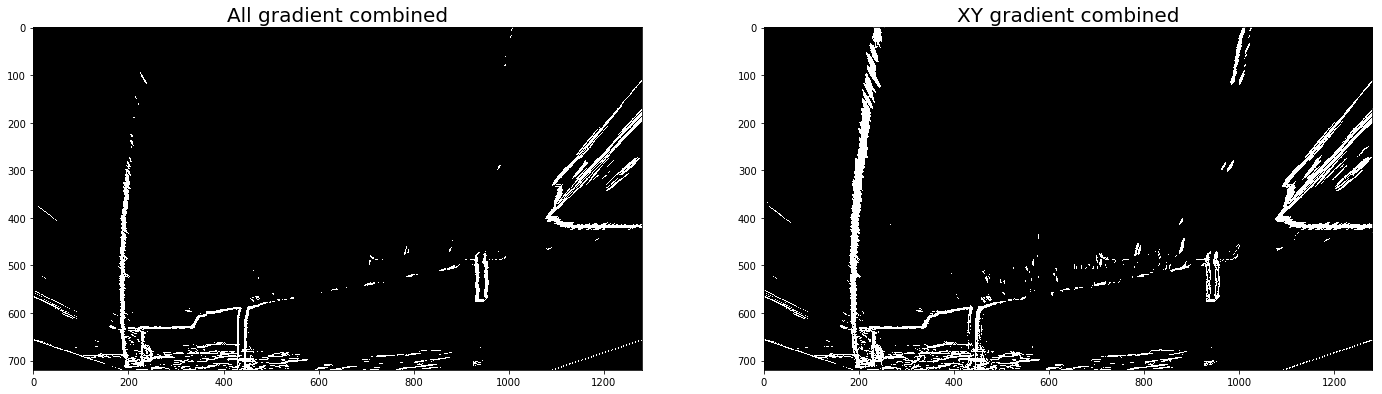

In [21]:
def combined_all_gradient(gradx, grady, mag_binary, dir_binary):
    combined_all = np.zeros_like(gradx)
    combined_all[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) )] = 1 # & (dir_binary == 1)
    return combined_all

def combinde_XY_gradient(gradx, grady):
    combined_XY = np.zeros_like(gradx)
    combined_XY[((gradx == 1) | (grady == 1))] = 1
    return combined_XY

### VISUALIZATION
def visu_gradient1(img, src, dst, mtx, dist):
    
    undist_img = undistort_img(img, mtx, dist)
    img_color_space, Minv_test = warp(undist_img, src, dst)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img_color_space, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img_color_space, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img_color_space, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(img_color_space, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    combined_all = combined_all_gradient(gradx, grady, mag_binary, dir_binary)
    combined_XY = combinde_XY_gradient(gradx, grady)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(combined_all, cmap='gray')
    ax1.set_title('All gradient combined', fontsize=20)
    ax2.imshow(combined_XY, cmap='gray')
    ax2.set_title('XY gradient combined', fontsize=20)
    
visu_gradient1(img_visu, src, dst, mtx, dist)

(720, 1280)


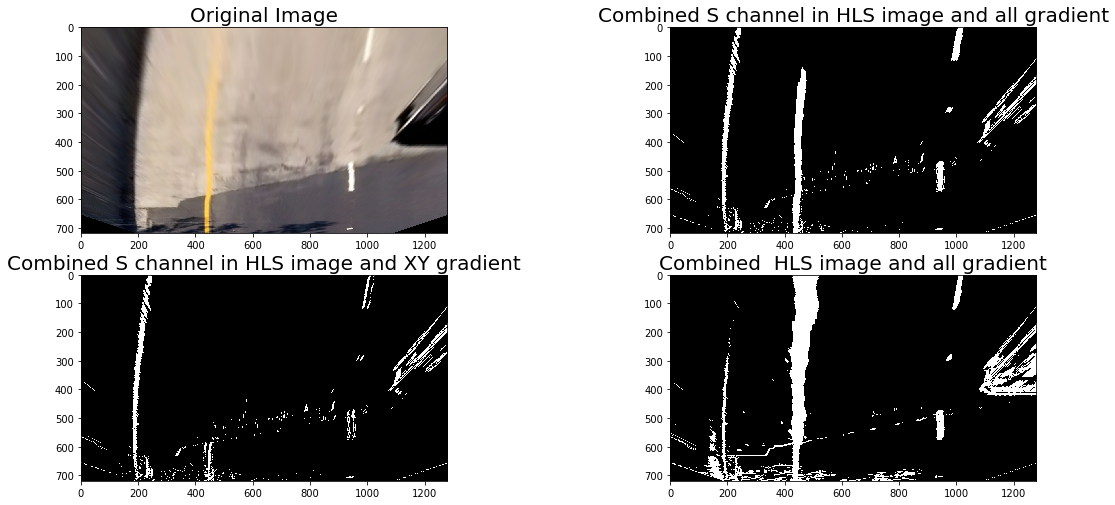

In [22]:
def combined_HLS_XY_gradient(gradx, grady, hls_binary):
    combined_color_sobelXY = np.zeros_like(gradx)
    combined_color_sobelXY[((gradx == 1) | (grady == 1) & (hls_binary == 1))] = 1
    return combined_color_sobelXY

def combined_HLS_all_gradient(gradx, grady, mag_binary, dir_binary, hls_binary):
    
    combined_all = combined_all_gradient(gradx, grady, mag_binary, dir_binary)
    
    combined_color_total_HLS = np.zeros_like(dir_binary)
    combined_color_total_HLS[((combined_all == 1) | (hls_binary == 1))] = 1 # hls_line
    return combined_color_total_HLS

def combined_All(gradx, grady, mag_binary, dir_binary, combined_white, combined_yellow):
    
    combined_all = combined_all_gradient(gradx, grady, mag_binary, dir_binary)

    combined_color_total = np.zeros_like(dir_binary)
    combined_color_total[((combined_all == 1) | (combined_white == 1) | (combined_yellow == 1))] = 1 
    return combined_color_total

### VISUALIZATION 
def visu_grandient2(img, src, dst, mtx, dist):
    
    ##
    undist_img = undistort_img(img, mtx, dist)
    img_color_space, Minv_test = warp(undist_img, src, dst)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img_color_space, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img_color_space, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img_color_space, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(img_color_space, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    ##
    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
    hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
    hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
    lab, L_lab, A_lab, B_lab = lab_select(img_color_space)
    
    ##
    hls_line = np.zeros_like(H_hls)
    hls_line[(H_hls > 0) & (H_hls < 50) & (S_hls > 150) & (S_hls < 255) & (L_hls > 100)] = 1

    hls_binary = np.zeros_like(S_hls)
    hls_binary[(S_hls > 90) & (S_hls <= 255)] = 1

    rgb_binary = np.zeros_like(S_hls)
    rgb_binary[(R_rgb > 220) ] = 1
    
    ##
    combined_white = combined_white_detection(img_color_space, R_rgb, G_rgb, B_rgb, L_hls)
    combined_yellow = combined_yellow_detection(img_color_space, U_yuv, B_lab)
    
    combined_color_sobelXY = combined_HLS_XY_gradient(gradx, grady, hls_binary)
    combined_color_total_HLS = combined_HLS_all_gradient(gradx, grady, mag_binary, dir_binary, hls_binary)
    combined_color_total = combined_All(gradx, grady, mag_binary, dir_binary, combined_white, combined_yellow)

    #############################
    combined_color_total = np.zeros_like(dir_binary)
    print(dir_binary.shape)
    combined_color_total[((gradx == 1) | (combined_white == 1) | (combined_yellow == 1))] = 1 
    #############################

    # Plot the result
    f, axs = plt.subplots(2, 2, figsize=(15, 7))
    #f.tight_layout()
    axs = axs.ravel()

    axs[0].imshow(img_color_space)
    axs[0].set_title('Original Image', fontsize=20)
    axs[1].imshow(combined_color_total, cmap='gray')
    axs[1].set_title('Combined S channel in HLS image and all gradient', fontsize=20)
    axs[2].imshow(combined_color_sobelXY, cmap='gray')
    axs[2].set_title('Combined S channel in HLS image and XY gradient', fontsize=20)
    axs[3].imshow(combined_color_total_HLS, cmap='gray')
    axs[3].set_title('Combined  HLS image and all gradient', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
visu_grandient2(img_visu, src, dst, mtx, dist)

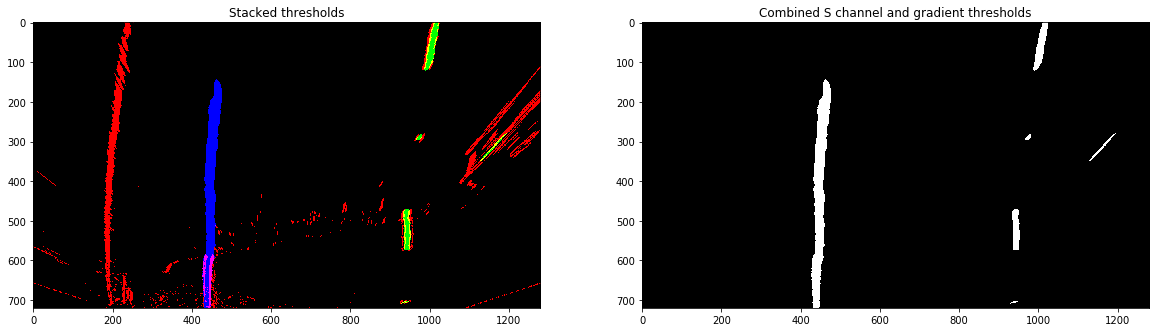

In [23]:
def visu_tansform_effect(img, src, dst, mtx, dist):
    
    ##
    undist_img = undistort_img(img, mtx, dist)
    img_color_space, Minv_test = warp(undist_img, src, dst)

    ##
    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
    hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
    hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
    lab, L_lab, A_lab, B_lab = lab_select(img_color_space)
    
    ##
    combined_white = combined_white_detection(img_color_space, R_rgb, G_rgb, B_rgb, L_hls)
    combined_yellow = combined_yellow_detection(img_color_space, U_yuv, B_lab)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img_color_space, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    
    combined_color_total = np.zeros_like(gradx)
    #combined_color_total[((gradx == 1) | (combined_white == 1) | (combined_yellow == 1))] = 1
    combined_color_total[((combined_white == 1) | (combined_yellow == 1))] = 1 
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(gradx), gradx, hls_binary)) * 255
    #color_binary = np.dstack(( combined_all, combined_white, combined_yellow))
    color_binary = np.dstack(( gradx, combined_white, combined_yellow))

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary*255)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_color_total, cmap='gray')
    
visu_tansform_effect(img_visu, src, dst, mtx, dist)

(720, 1280)


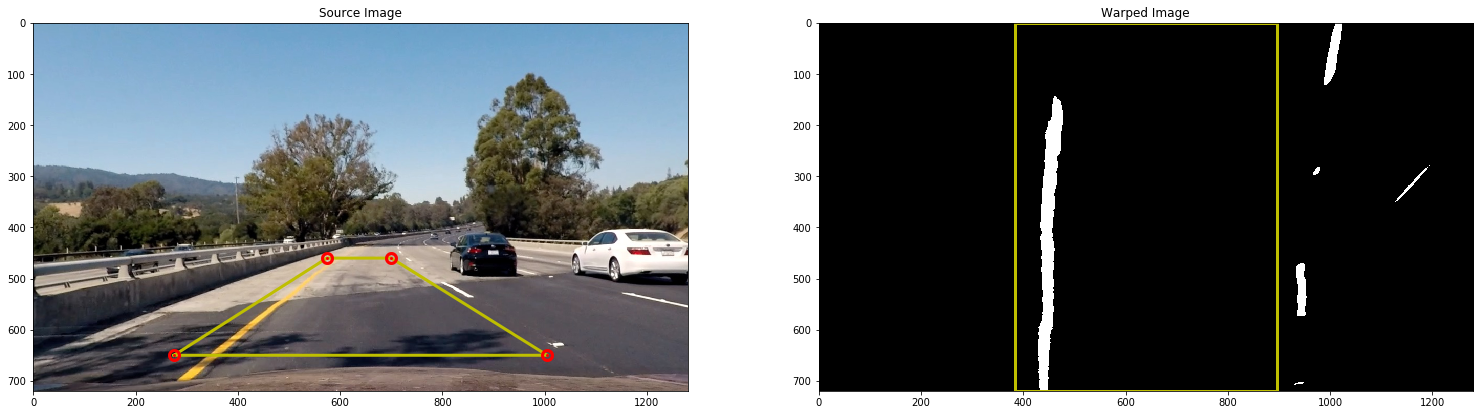

In [24]:
def visu_binary_result(img, src, dst, mtx, dist):

    ##
    undist_img = undistort_img(img, mtx, dist)
    img_color_space, Minv_test = warp(undist_img, src, dst)

    ##
    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
    hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
    hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
    lab, L_lab, A_lab, B_lab = lab_select(img_color_space)
    
    ##
    combined_white = combined_white_detection(img_color_space, R_rgb, G_rgb, B_rgb, L_hls)
    combined_yellow = combined_yellow_detection(img_color_space, U_yuv, B_lab)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img_color_space, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    
    ##
    combined_color_total = np.zeros_like(gradx)
    #combined_color_total[((gradx == 1) | (combined_white == 1) | (combined_yellow == 1))] = 1
    combined_color_total[((combined_white == 1) | (combined_yellow == 1))] = 1
    
    # Get perspective transform
    #warped_img, Minv_bis = warp(combined_color_total, src, dst)
    #print(warped_img.shape)

    #print(combined_color_total.shape)
    # Binarize "warped_img" image
    binary_warped = np.zeros_like(combined_color_total)
    binary_warped[(combined_color_total > 0.9)] = 1
    #binary_warped = binary_warped*255
    print(binary_warped.shape)

    x1 = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
    y1 = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]

    x2 = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
    y2 = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]
    
    # Visualisation undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    h, w = img.shape[:2]  # h : height of the image, w : width of the image

    ax1.plot(x1, y1, 'y', linewidth=3)#, solid_capstyle='round', zorder=2)
    ax1.plot(src[0][0], src[0][1], 'r.', markeredgewidth=10)
    ax1.plot(src[1][0], src[1][1], 'r.', markeredgewidth=10)
    ax1.plot(src[2][0], src[2][1], 'r.', markeredgewidth=10)
    ax1.plot(src[3][0], src[3][1], 'r.', markeredgewidth=10)
    ax1.imshow(undist_img, cmap='gray')
    ax1.set_title('Source Image')
    ax2.plot(x2, y2, 'y', linewidth=3)
    ax2.imshow(binary_warped, cmap='gray')
    ax2.set_title('Warped Image')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
visu_binary_result(img_visu, src, dst, mtx, dist)

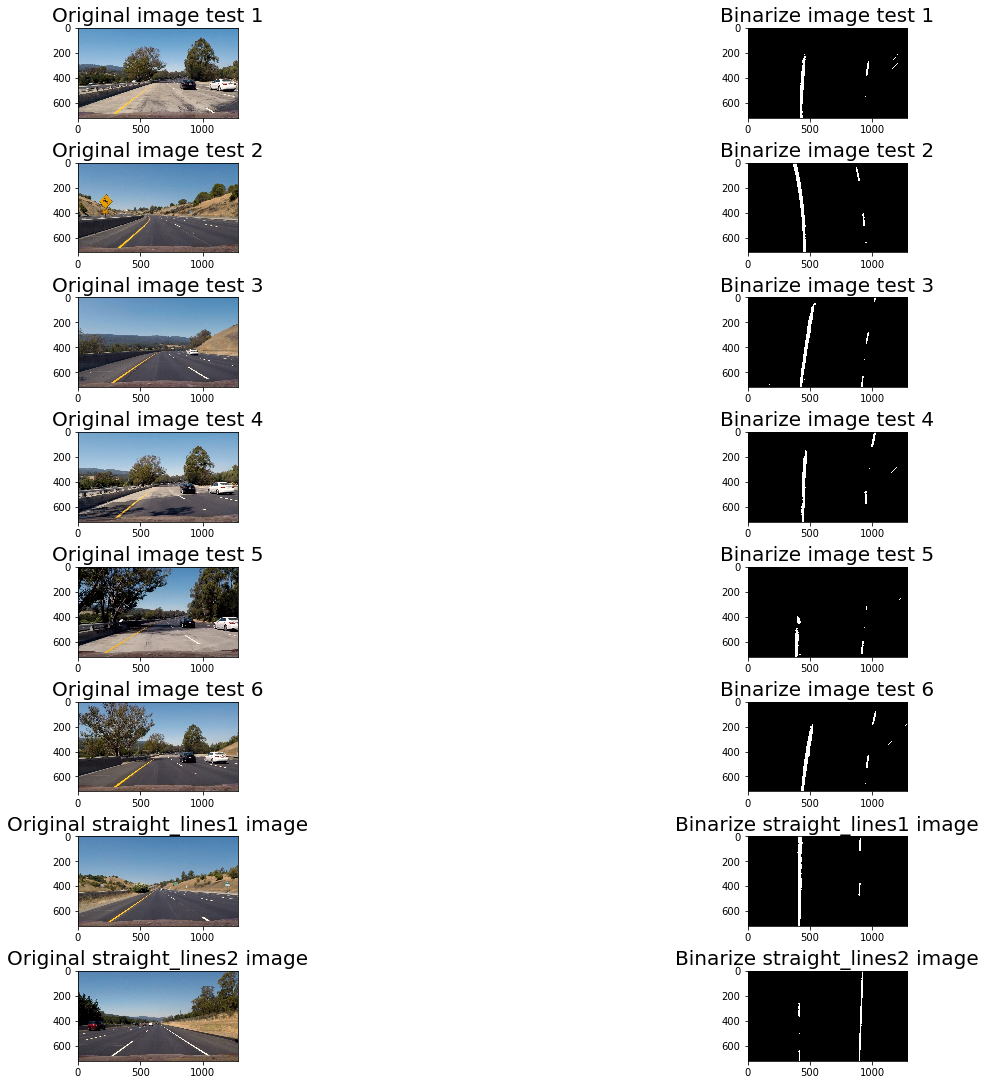

In [25]:
def visu_all_test_images(src, dst, mtx, dist):
    
    images_test = glob.glob('C:/Udacity/CarND-Advanced-Lane-Lines-master/test_images/test*.jpg')

    def pipeline_visu_test_images(img, src, dst, mtx, dist):
        
        ##
        undist_img = undistort_img(img, mtx, dist)
        img_color_space, Minv_test = warp(undist_img, src, dst)

        ##
        rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
        hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
        hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
        yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
        lab, L_lab, A_lab, B_lab = lab_select(img_color_space)
    
        ##
        combined_white = combined_white_detection(img_color_space, R_rgb, G_rgb, B_rgb, L_hls)
        combined_yellow = combined_yellow_detection(img_color_space, U_yuv, B_lab)
    
        # Choose a Sobel kernel size
        ksize = 3 # Choose a larger odd number to smooth gradient measurements
    
        # Apply each of the thresholding functions
        gradx = abs_sobel_thresh(img_color_space, orient='x', sobel_kernel=ksize, thresh=(20, 100))
        
        ##
        combined_color_total = np.zeros_like(gradx)
        #combined_color_total[((gradx == 1) | (combined_white == 1) | (combined_yellow == 1))] = 1
        combined_color_total[((combined_white == 1) | (combined_yellow == 1))] = 1

        #print(combined_color_total.shape)
        # Binarize "warped_img" image
        binary_warped = np.zeros_like(combined_color_total)
        binary_warped[(combined_color_total > 0.9)] = 1
        
        return binary_warped
    
    # Visualize all binarize test images
    binarize_image = []
    original_image = []

    def process_visu_test_images(fname, binarize_image, original_image):
        image2 = mpimg.imread(fname)
        original_image.append(image2)
        binarize_image.append(pipeline_visu_test_images(image2, src, dst, mtx, dist))
        
        return binarize_image, original_image
    
    ## Test images 1 to 6
    for fname in images_test:
        """
        Test pipeline on test images
        """
        binarize_image, original_image = process_visu_test_images(fname, binarize_image, original_image)
        
    ## straight_lines1 and straight_lines2 images
    binarize_image, original_image = process_visu_test_images('C:/Udacity/CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg', binarize_image, original_image)
    binarize_image, original_image = process_visu_test_images('C:/Udacity/CarND-Advanced-Lane-Lines-master/test_images/straight_lines2.jpg', binarize_image, original_image)
    
    fig, axs = plt.subplots(8,2, figsize=(24, 19))
    fig.subplots_adjust(hspace = .5, wspace=0)
    #fig.tight_layout()
    axs = axs.ravel()

    axs[0].imshow(original_image[0], cmap='gray')
    axs[0].set_title('Original image test 1', fontsize=20)
    axs[1].imshow(binarize_image[0], cmap='gray')
    axs[1].set_title('Binarize image test 1', fontsize=20)
    
    axs[2].imshow(original_image[1], cmap='gray')
    axs[2].set_title('Original image test 2', fontsize=20)
    axs[3].imshow(binarize_image[1], cmap='gray')
    axs[3].set_title('Binarize image test 2', fontsize=20)
    
    axs[4].imshow(original_image[2], cmap='gray')
    axs[4].set_title('Original image test 3', fontsize=20)
    axs[5].imshow(binarize_image[2], cmap='gray')
    axs[5].set_title('Binarize image test 3', fontsize=20)

    axs[6].imshow(original_image[3], cmap='gray')
    axs[6].set_title('Original image test 4', fontsize=20)
    axs[7].imshow(binarize_image[3], cmap='gray')
    axs[7].set_title('Binarize image test 4', fontsize=20)
    
    axs[8].imshow(original_image[4], cmap='gray')
    axs[8].set_title('Original image test 5', fontsize=20)
    axs[9].imshow(binarize_image[4], cmap='gray')
    axs[9].set_title('Binarize image test 5', fontsize=20)
    
    axs[10].imshow(original_image[5], cmap='gray')
    axs[10].set_title('Original image test 6', fontsize=20)
    axs[11].imshow(binarize_image[5], cmap='gray')
    axs[11].set_title('Binarize image test 6', fontsize=20)
    
    axs[12].imshow(original_image[6], cmap='gray')
    axs[12].set_title('Original straight_lines1 image', fontsize=20)
    axs[13].imshow(binarize_image[6], cmap='gray')
    axs[13].set_title('Binarize straight_lines1 image', fontsize=20)
    
    axs[14].imshow(original_image[7], cmap='gray')
    axs[14].set_title('Original straight_lines2 image', fontsize=20)
    axs[15].imshow(binarize_image[7], cmap='gray')
    axs[15].set_title('Binarize straight_lines2 image', fontsize=20)
    
visu_all_test_images(src, dst, mtx, dist)

=== FINDING LINES ===

In [26]:
def sliding_window(img):

    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #print(leftx_base)
    #print(rightx_base)
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print(nonzeroy)
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    binary_warped = img
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image 
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        #print((nonzeroy >= win_y_low).nonzero())
        #print(good_left_inds)
        #print(good_right_inds)
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    #print(left_lane_inds)
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #print(left_lane_inds.shape)
    #print(right_lane_inds.shape)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return leftx, lefty, rightx, righty, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy

=== VISUALIZATION ===

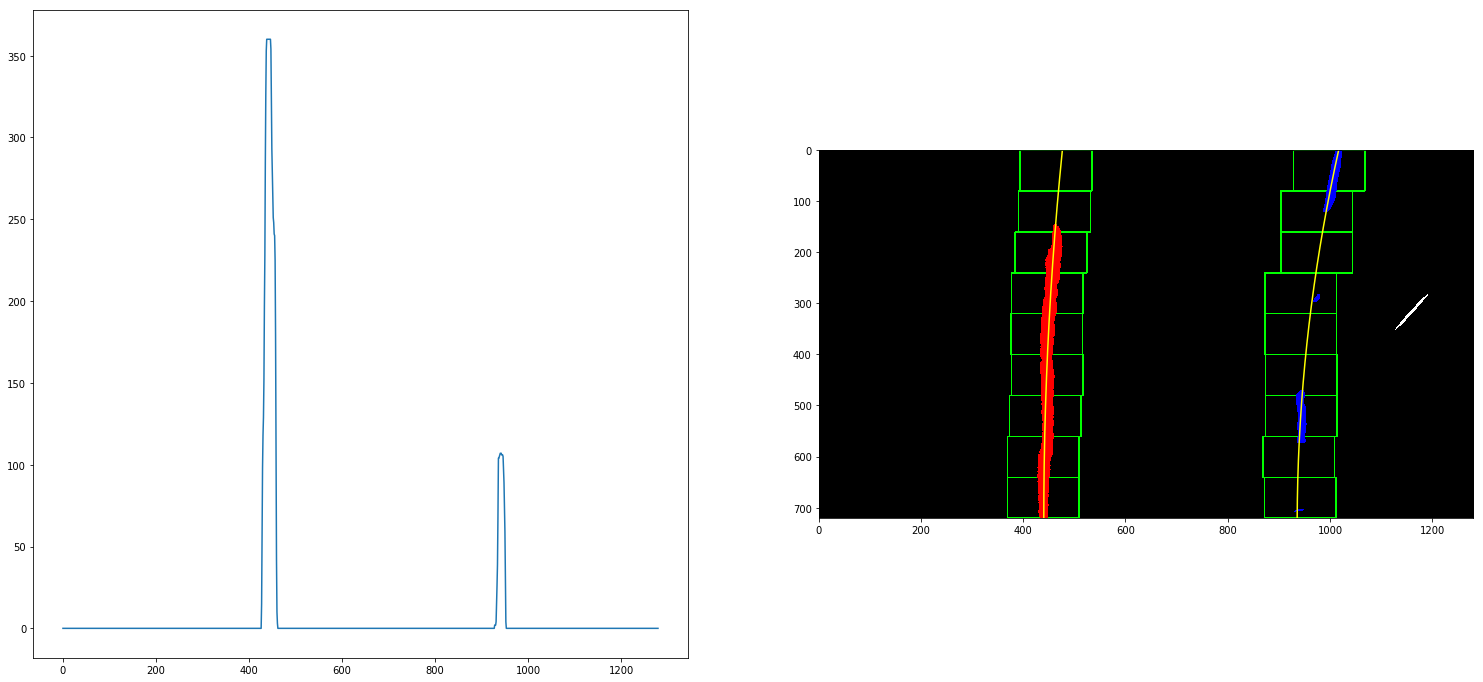

In [27]:
def visu_sliding_line(img, src, dst, mtx, dist):

    ##
    undist_img = undistort_img(img, mtx, dist)
    img_color_space, Minv_test = warp(undist_img, src, dst)

    ##
    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
    hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
    hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
    lab, L_lab, A_lab, B_lab = lab_select(img_color_space)
    
    ##
    combined_white = combined_white_detection(img_color_space, R_rgb, G_rgb, B_rgb, L_hls)
    combined_yellow = combined_yellow_detection(img_color_space, U_yuv, B_lab)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img_color_space, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    
    ##
    combined_color_total = np.zeros_like(gradx)
    #combined_color_total[((gradx == 1) | (combined_white == 1) | (combined_yellow == 1))] = 1
    combined_color_total[((combined_white == 1) | (combined_yellow == 1))] = 1
    
    # Get perspective transform
    #warped_img, Minv_bis = warp(combined_color_total, src, dst)
    #print(warped_img.shape)

    #print(combined_color_total.shape)
    # Binarize "warped_img" image
    binary_warped = np.zeros_like(combined_color_total)
    binary_warped[(combined_color_total > 0.9)] = 1
    
    # Assuming you have created a warped binary image called "binary_warped"
    leftx, lefty, rightx, righty, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = sliding_window(binary_warped)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #print(nonzeroy[right_lane_inds])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    ax1.plot(histogram)

    ax2.imshow(out_img)
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
visu_sliding_line(img_visu, src, dst, mtx, dist)

=== Skip the sliding windows step once you know where the lines are ===

In [28]:
def sliding_window_with_prev_frame(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 70
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return leftx, lefty, rightx, righty, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy

=== VISUALIZATION ===

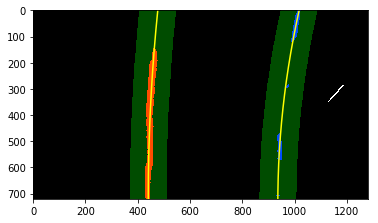

In [29]:
def visu_sliding_line_prev_frame(img, src, dst, mtx, dist):

    ##
    undist_img = undistort_img(img, mtx, dist)
    img_color_space, Minv_test = warp(undist_img, src, dst)

    ##
    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img_color_space)
    hls, H_hls, L_hls, S_hls = hls_select(img_color_space)
    hsv, H_hsv, S_hsv, V_hsv = hsv_select(img_color_space)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img_color_space)
    lab, L_lab, A_lab, B_lab = lab_select(img_color_space)
    
    ##
    combined_white = combined_white_detection(img_color_space, R_rgb, G_rgb, B_rgb, L_hls)
    combined_yellow = combined_yellow_detection(img_color_space, U_yuv, B_lab)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img_color_space, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    
    ##
    combined_color_total = np.zeros_like(gradx)
    #combined_color_total[((gradx == 1) | (combined_white == 1) | (combined_yellow == 1))] = 1
    combined_color_total[((combined_white == 1) | (combined_yellow == 1))] = 1
    
    # Get perspective transform
    #warped_img, Minv_bis = warp(combined_color_total, src, dst)
    #print(warped_img.shape)

    #print(combined_color_total.shape)
    # Binarize "warped_img" image
    binary_warped = np.zeros_like(combined_color_total)
    binary_warped[(combined_color_total > 0.9)] = 1
    
    # Assuming you have created a warped binary image called "binary_warped"
    leftx, lefty, rightx, righty, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = sliding_window(binary_warped)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #
    left_fit_prev = left_fit
    right_fit_prev = right_fit

    # Assuming you have created a warped binary image called "binary_warped"
    leftx, lefty, rightx, righty, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = sliding_window_with_prev_frame(binary_warped, left_fit_prev, right_fit_prev)
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    margin = 70
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
visu_sliding_line_prev_frame(img_visu, src, dst, mtx, dist)

=== FINDING CURVATURE ===

In [30]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
#y_eval = np.max(ploty)
def calculate_radius_curvature(lefty, righty, left_fit, right_fit):
    y_eval_left = np.max(lefty)
    y_eval_right = np.max(righty)

    left_curverad = ((1 + (2*left_fit[0]*y_eval_left + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval_right + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad, y_eval_left, y_eval_right


### VISUALIZATION
#left_curverad, right_curverad, y_eval_left, y_eval_right = calculate_radius_curvature(lefty, righty)

#print(left_curverad, right_curverad)

In [31]:
def calculate_meter_curvature(leftx, lefty, rightx, righty, y_eval_left, y_eval_right, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad_meter = ((1 + (2*left_fit_cr[0]*y_eval_left*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_meter = ((1 + (2*right_fit_cr[0]*y_eval_right*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    # Offset from center of lane
    car_pos = 1280/2
    left_fit_x_pos = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fit_x_pos = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    lane_center_pos = (left_fit_x_pos + right_fit_x_pos) /2
    offset_car_center = (car_pos - lane_center_pos) * xm_per_pix
    
    return left_curverad_meter, right_curverad_meter, offset_car_center

### VISUALIZATION
#left_curverad_meter, right_curverad_meter, offset_car_center = calculate_meter_curvature(leftx, lefty, rightx, righty, y_eval_left, y_eval_right, left_fit, right_fit)

#print(left_curverad_meter, 'm', right_curverad_meter, 'm')
#print(offset_car_center, 'm')

=== DRAWING LANE ON IMAGE ===

In [32]:
def draw_line(undist_img, binary_warped, left_fitx, right_fitx, ploty, Minv):
   
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    return result

###VISUALIZE
#result = draw_line(binary_warped, left_fitx, right_fitx, ploty)
#plt.imshow(result)
#print

In [33]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

=== PIPELINE ===
=========

In [34]:
def pipeline(img2):
    
    # Undistort image
    undist_img = cv2.undistort(img2, mtx, dist, None, mtx)
    
    
    
    
    # Color transform
    rgb, R_rgb, G_rgb, B_rgb = rgb_select(img2)
    hls, H_hls, L_hls, S_hls = hls_select(img2)
    #hsv, H_hsv, S_hsv, V_hsv = hsv_select(img2)
    yuv, Y_yuv, U_yuv, V_yuv = yuv_select(img2)
    lab, L_lab, A_lab, B_lab = lab_select(img2)
    
    combined_white = combined_white_detection(img2, R_rgb, G_rgb, B_rgb, L_hls)
    combined_yellow = combined_yellow_detection(img2, U_yuv, B_lab)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    
    # Gradient transform
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    
    # Combined all transform and binarize image
    combined_color_total = np.zeros_like(gradx)
    #combined_color_total[((gradx == 1) | (combined_white == 1) | (combined_yellow == 1))] = 1
    combined_color_total[((combined_white == 1) | (combined_yellow == 1))] = 1
    binary_warped = np.zeros_like(combined_color_total)
    binary_warped[(combined_color_total > 0.9)] = 1
    
    
    #warped, Minv = warp(img2, src, dst)
    binary_warped, Minv = warp(binary_warped, src, dst)
    
    # Sliding window
    leftx, lefty, rightx, righty, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = sliding_window(binary_warped)
    
    # Sliding window with previous frame
    #leftx, lefty, rightx, righty, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = sliding_window_with_prev_frame(binary_warped, left_fit_prev, right_fit_prev)
    
    # Radius curvature
    left_curverad, right_curverad, y_eval_left, y_eval_right = calculate_radius_curvature(lefty, righty, left_fit, right_fit)
    
    # Meter curvature
    left_curverad_meter, right_curverad_meter, offset_car_center = calculate_meter_curvature(leftx, lefty, rightx, righty, y_eval_left, y_eval_right, left_fit, right_fit)
       
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    result2 = draw_line(undist_img, binary_warped, left_fitx, right_fitx, ploty, Minv)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(right_curverad_meter) + 'm'
    cv2.putText(result2,text,(10,50), font, 2,(255,255,255),2,cv2.LINE_AA)
    
    text = 'Offset center: ' + '{:04.2f}'.format(offset_car_center) + 'm'
    cv2.putText(result2,text,(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    
    return result2

=== TEST IMAGES ===
===========

Text(0.5,1,'Image test 6')

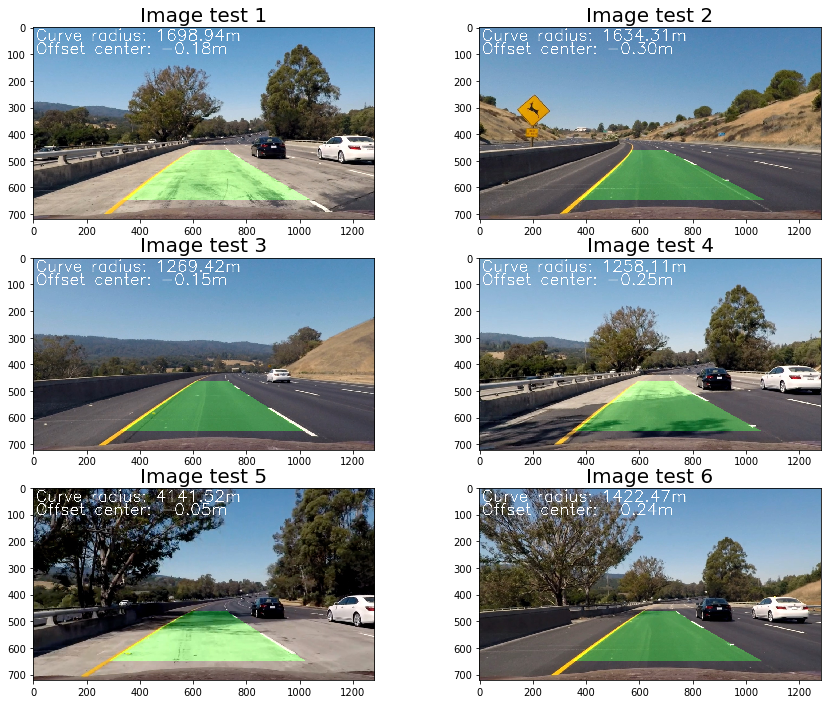

In [35]:
images_test = glob.glob('C:/Udacity/CarND-Advanced-Lane-Lines-master/test_images/test*.jpg')

plot_image = []

for fname in images_test:
    """
    Test pipeline on test images
    """
    #print(fname)
    image2 = mpimg.imread(fname)
    plot_image.append(pipeline(image2))
    
fig, axs = plt.subplots(3,2, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=0)
#fig.tight_layout()
axs = axs.ravel()

axs[0].imshow(plot_image[0], cmap='gray')
axs[0].set_title('Image test 1', fontsize=20)
axs[1].imshow(plot_image[1], cmap='gray')
axs[1].set_title('Image test 2', fontsize=20)
axs[2].imshow(plot_image[2], cmap='gray')
axs[2].set_title('Image test 3', fontsize=20)

axs[3].imshow(plot_image[3], cmap='gray')
axs[3].set_title('Image test 4', fontsize=20)
axs[4].imshow(plot_image[4], cmap='gray')
axs[4].set_title('Image test 5', fontsize=20)
axs[5].imshow(plot_image[5], cmap='gray')
axs[5].set_title('Image test 6', fontsize=20)

=== VIDEO PIPELINE ===
============

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return pipeline(image)

In [38]:
video_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_input = VideoFileClip("project_video.mp4")
video_generate = video_input.fl_image(process_image) #NOTE: this function expects color images!!
%time video_generate.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [04:12<00:00,  5.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 13s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))